In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
from datetime import datetime, date
import json
from xgrads import open_CtlDataset
import geopandas as gpd
import requests
import hydrofunctions as hf
import matplotlib.pyplot as plt
import folium 
%matplotlib inline

In [2]:
# Choose a domain
domain = 'BRIS'

# calibration dates
# start calibration date    
st_dtcal = '2011-10-01'
# end calibration date
ed_dtcal = '2018-09-30'

# paths 
SMpath = '/nfs/attic/dfh/2020_NPRB/domain_'+domain+'/snowmodel2023_cfsv2/'
#hydroflow path 
HFpath = '/nfs/attic/dfh/2020_NPRB/domain_'+domain+'/snowmodel2023_cfsv2/hydroflowcal1/'
# data location
datapath = '/nfs/attic/dfh/2020_NPRB/data/'
# stream gauge data
flowpath = datapath+'stream_gage/'+domain+'/'
# calibration disgharge data
flowdatacal = flowpath+domain+'_discharge_cfs_'+st_dtcal+'_'+ed_dtcal+'.csv'
# calibration station gdf
flowstncal = flowpath+domain+'_gage_meta_'+st_dtcal+'_'+ed_dtcal+'.geojson'
# calibration station gdf projected
flowstnprojcal = flowpath+domain+'_gage_meta_proj_'+st_dtcal+'_'+ed_dtcal+'.geojson'

#path to NPRB domains
domains_resp = requests.get("https://raw.githubusercontent.com/NPRB/02_preprocess_python/main/NPRB_domains.json")
domains = domains_resp.json()

In [3]:
stnproj = gpd.read_file(flowstnprojcal)

This notebook requires manual examination of each station to retrieve the i, j pair from the hydroflow data. Manual corrections are often required to match the station location to the stream channel that was determined in hydroflow. 

# find i j pair for each station 

Need to find the i j pair for each of the gage locations to extract hydroflow output. To do this - each station locaiton needs to be compared to the disgarge output to make sure it align with the computed river network. 

In [4]:
#use topo to get spatial info
# SM forcing files 
SMdatapath = datapath+'SMinputs/'+domain+'/'
# dem ascii file
demasc = SMdatapath+domain+'_dem.asc'

topo = rxr.open_rasterio(demasc)

In [5]:
#hydroflow discharge data using pixel centers 
ctlFile = HFpath+'disc_s10_f1.ctl'

q = open_CtlDataset(ctlFile)
q=q.assign_coords({"lat": np.flipud(topo.y.values)-int(domains[domain]['cellsize']),"lon": topo.x.values-int(domains[domain]['cellsize'])})

q

,Array,Chunk
Bytes,11.10 GiB,4.45 MiB
Shape,"(2557, 1, 1228, 949)","(1, 1, 1228, 949)"
Count,2557 Tasks,2557 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,11.10 GiB,4.45 MiB
Shape,"(2557, 1, 1228, 949)","(1, 1, 1228, 949)"
Count,2557 Tasks,2557 Chunks
Type,float32,numpy.ndarray


In [6]:
# domain shapefile
shp = gpd.read_file('/nfs/attic/dfh/2020_NPRB/data/gis/'+domain+'/'+domain+'.json')
shpproj = shp.to_crs(stnproj.crs)

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

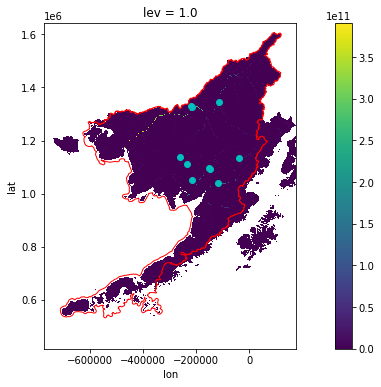

In [7]:
qsum = q.slow.isel(lev=0).sum('time')+q.fast.isel(lev=0).sum('time')

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
shpproj.plot(ax=ax,facecolor='None',edgecolor='r')

In [8]:
# Add custom base maps to folium
basemaps = {
    'Google Maps': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = True,
        control = True
    ),
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = True,
        control = True
    ),
    'Google Satellite Hybrid': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Esri Satellite': folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True
    )
}

In [9]:
stnproj

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no,geometry
0,USGS,15298040,CHULITNA R 5MI AB MOUTH NR PORT ALSWORTH AK,ST,601215.6,1544208.0,60.203659,-154.704435,G,1,...,None,Y,None,None,None,None,None,None,None,POINT (-38916.674 1135274.366)
1,USGS,15300520,KASKANAK C NR IGIUGIG AK,ST,592018.0,1560431.0,59.337622,-156.077443,G,S,...,None,Y,None,None,None,None,None,None,None,POINT (-117781.255 1040064.866)
2,USGS,15301500,ALLEN R NR ALEKNAGIK AK,ST,600917.0,1584404.0,60.153994,-158.736692,M,S,...,None,NYNNNNNN,None,None,None,None,None,None,None,POINT (-261858.623 1138855.835)
3,USGS,15302000,NUYAKUK R NR DILLINGHAM AK,ST,595608.0,1581116.0,59.934830,-158.190006,M,U,...,None,NNNNNNNN,None,None,None,None,None,None,None,POINT (-233224.290 1112362.774)
4,USGS,15302300,MULCHATNA R AB STUYAHOK R NR NEW STUYAHOK AK,ST,595018.0,1564130.0,59.837623,-156.693869,G,S,...,None,Y,None,None,None,None,None,None,None,POINT (-150445.478 1097183.963)
5,USGS,15302320,STUYAHOK R NR NEW STUYAHOK AK,ST,594835.0,1563953.0,59.809011,-156.666923,G,S,...,None,Y,None,None,None,None,None,None,None,POINT (-149069.859 1093926.244)
6,USGS,15302812,KOKWOK R 22 MI AB NUSHAGAK R NR EKWOK AK,ST,592454.0,1574815.0,59.415000,-157.804167,N,R,...,U,None,None,None,None,None,None,None,None,POINT (-215100.292 1053036.526)
7,USGS,15303900,KUSKOKWIM R AT LISKYS CROSSING NR STONY RIVER AK,ST,620307.0,1561238.0,62.051277,-156.212907,M,S,...,None,NYNNNNNN,None,None,None,None,None,None,None,POINT (-115347.992 1343629.810)
8,USGS,15304000,KUSKOKWIM R AT CROOKED CREEK AK,ST,615210.0,1580641.0,61.868744,-158.113785,M,T,...,None,NYNNNNNN,None,None,None,None,None,None,None,POINT (-215597.581 1327975.727)
9,USGS,15304010,CROOKED C AB AIRPORT RD NR CROOKED CREEK AK,ST,615324.0,1580916.0,61.889301,-158.156842,G,S,...,None,NYNNNNNN,None,None,None,None,None,None,None,POINT (-217707.423 1330410.497)


In [10]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

# BRIS stations for cal
['15304000','15302000','15298040']

# 15298040

In [12]:
i=0
stnproj.site_no[i]

'15298040'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

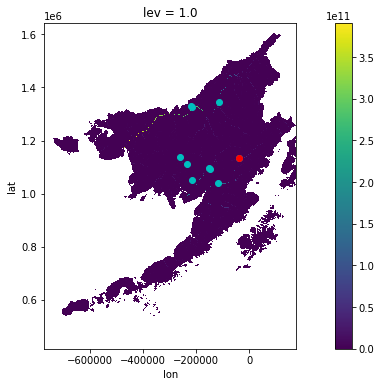

In [13]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15298040


(-46500.0, -30500.0)

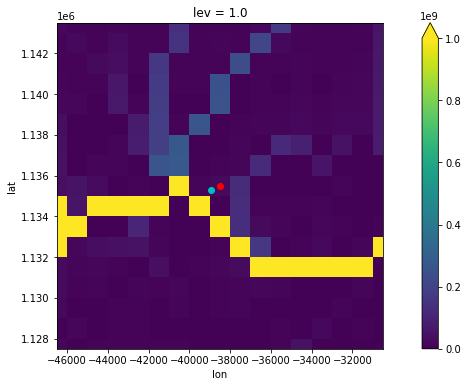

In [14]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e9,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-8000,dftest.y.values[0]+8000])
plt.xlim([dftest.x.values[0]-8000,dftest.x.values[0]+8000])

In [15]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)


yidx =  719
xidx =  733


(-47500.0, -31500.0)

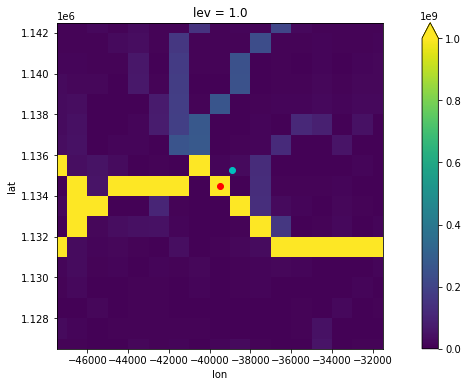

In [16]:
yidx = int(np.where(q.lat == slow.lat)[0]-1)
xidx = int(np.where(q.lon == slow.lon)[0]-1)
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e9,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-8000,dftest.y.values[0]+8000])
plt.xlim([dftest.x.values[0]-8000,dftest.x.values[0]+8000])

In [17]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

yidx fixed =  718
xidx fixed =  732


In [18]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [19]:
#indicies to save out
xidx1 = int(xidx)
yidx1 = int(yidx)

# 15300520

In [20]:
i=1
stnproj.site_no[i]

'15300520'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

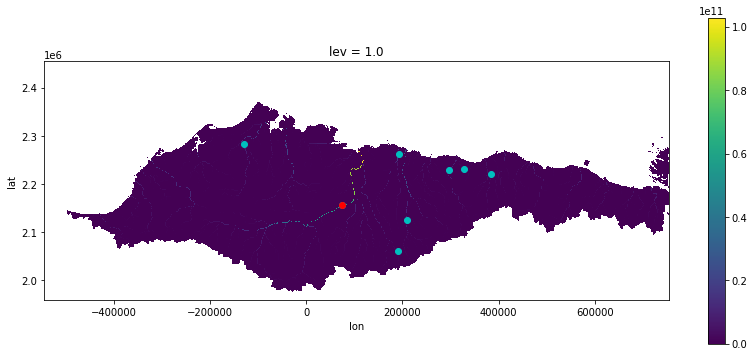

In [68]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15875000


(62500.0, 86500.0)

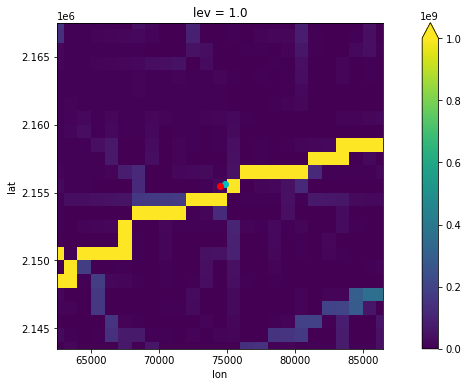

In [129]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e9,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-12000,dftest.y.values[0]+12000])
plt.xlim([dftest.x.values[0]-12000,dftest.x.values[0]+12000])

In [130]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  196
xidx =  618


(67500.0, 83500.0)

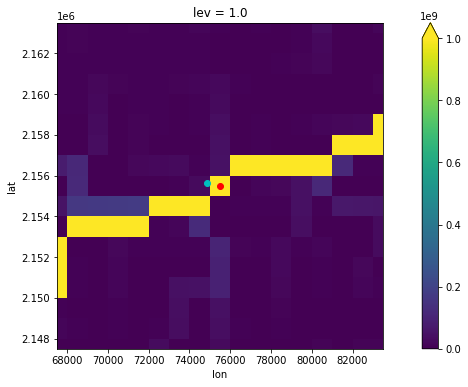

In [131]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0]+1)
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e9,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-8000,dftest.y.values[0]+8000])
plt.xlim([dftest.x.values[0]-8000,dftest.x.values[0]+8000])

In [132]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

yidx fixed =  196
xidx fixed =  619


In [73]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [22]:
#indicies to save out
xidx2 = np.nan
yidx2 = np.nan

# 

In [21]:
i=2
stnproj.site_no[i]

'15301500'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

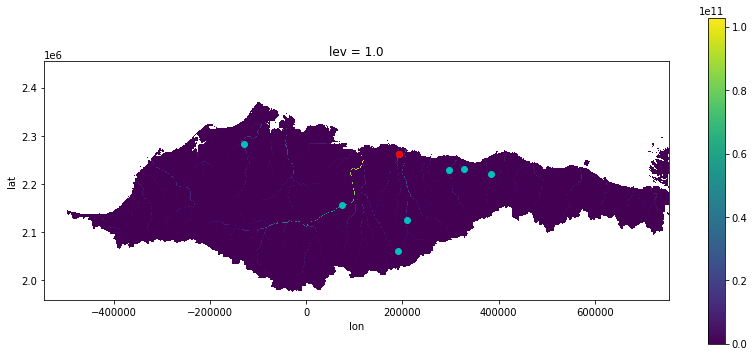

In [76]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15896000


(188500.0, 198500.0)

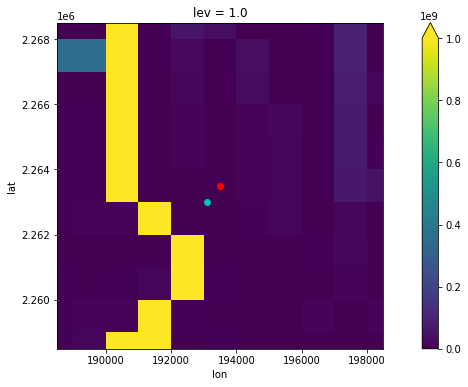

In [135]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e9,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-5000,dftest.y.values[0]+5000])
plt.xlim([dftest.x.values[0]-5000,dftest.x.values[0]+5000])

In [136]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  304
xidx =  737


(183500.0, 199500.0)

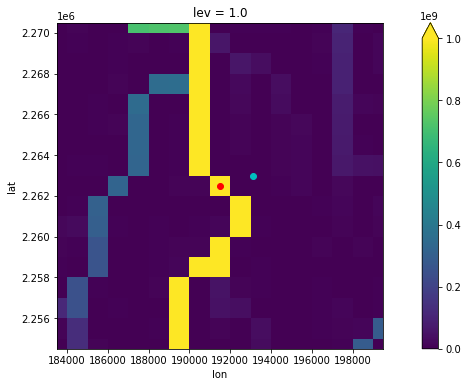

In [137]:
yidx = int(np.where(q.lat == slow.lat)[0]-1)
xidx = int(np.where(q.lon == slow.lon)[0]-2)
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e9,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-8000,dftest.y.values[0]+8000])
plt.xlim([dftest.x.values[0]-8000,dftest.x.values[0]+8000])

In [138]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

yidx fixed =  303
xidx fixed =  735


In [79]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [23]:
#indicies to save out
xidx3 = np.nan
yidx3 = np.nan

# 15302000

In [24]:
i=3
stnproj.site_no[i]

'15302000'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

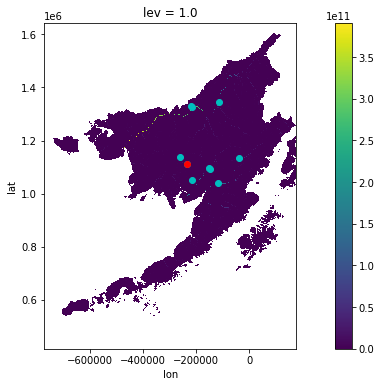

In [25]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15302000


(-241500.0, -225500.0)

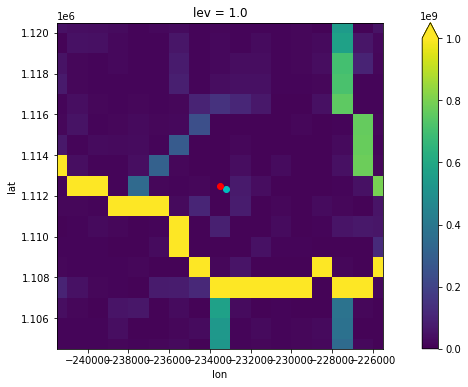

In [36]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e9,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-8000,dftest.y.values[0]+8000])
plt.xlim([dftest.x.values[0]-8000,dftest.x.values[0]+8000])

In [37]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  696
xidx =  538


(-240500.0, -225500.0)

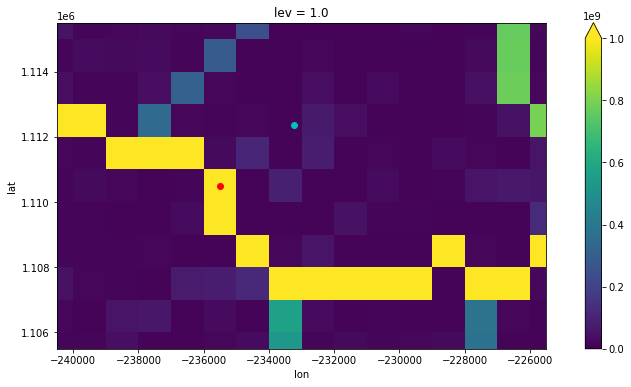

In [38]:
yidx = int(np.where(q.lat == slow.lat)[0]-2)
xidx = int(np.where(q.lon == slow.lon)[0]-2)
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e9,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-5000,dftest.y.values[0]+5000])
plt.xlim([dftest.x.values[0]-5000,dftest.x.values[0]+10000])

In [39]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

yidx fixed =  694
xidx fixed =  536


In [40]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [41]:
#indicies to save out
xidx4 = int(xidx)
yidx4 = int(yidx)

# 15908000

In [146]:
i=4
stnproj.site_no[i]

'15908000'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

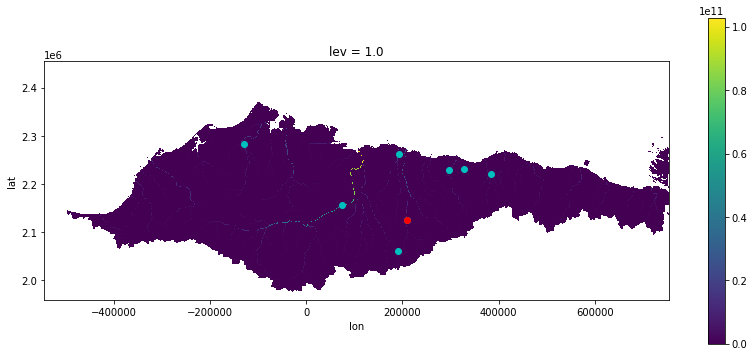

In [99]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15908000


(201500.0, 217500.0)

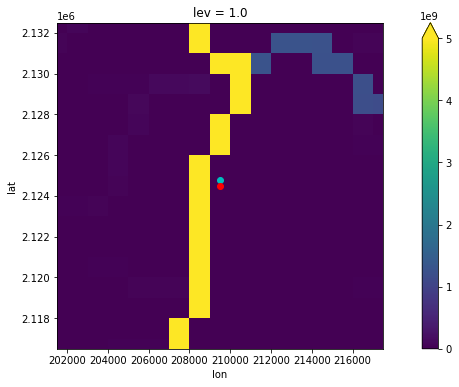

In [147]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=5e9,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-8000,dftest.y.values[0]+8000])
plt.xlim([dftest.x.values[0]-8000,dftest.x.values[0]+8000])

In [148]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  165
xidx =  753


(200500.0, 216500.0)

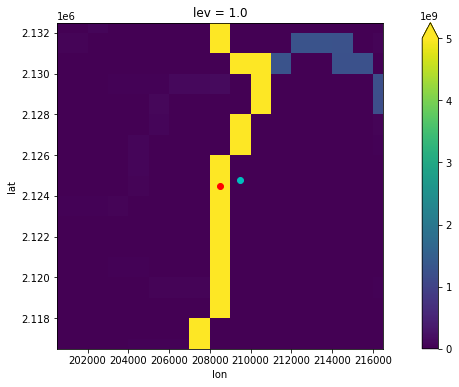

In [149]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0]-1)
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=5e9,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-8000,dftest.y.values[0]+8000])
plt.xlim([dftest.x.values[0]-8000,dftest.x.values[0]+8000])

In [150]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

yidx fixed =  165
xidx fixed =  752


In [105]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [42]:
#indicies to save out
xidx5 = np.nan
yidx5 = np.nan

# 15955000

In [109]:
i=5
stnproj.site_no[i]

'15955000'

<AxesSubplot:title={'center':'lev = 1.0'}, xlabel='lon', ylabel='lat'>

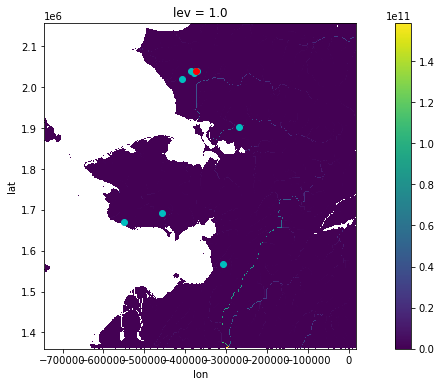

In [51]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15746980


(-379500.0, -369500.0)

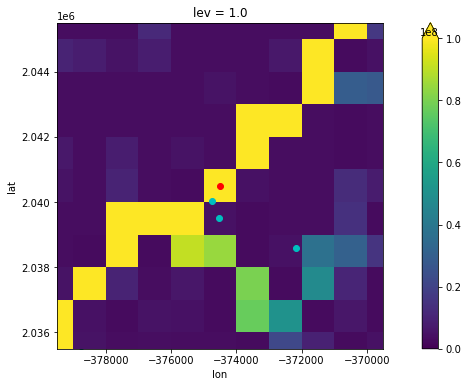

In [52]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e8,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-5000,dftest.y.values[0]+5000])
plt.xlim([dftest.x.values[0]-5000,dftest.x.values[0]+5000])

In [53]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  680
xidx =  370


In [54]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [43]:
#indicies to save out
xidx6 = np.nan
yidx6 = np.nan

# 15960000

In [110]:
i=6
stnproj.site_no[i]

'15960000'

<AxesSubplot:title={'center':'lev = 1.0'}, xlabel='lon', ylabel='lat'>

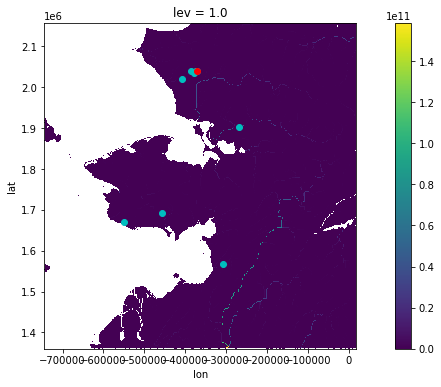

In [57]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15746988


(-380500.0, -364500.0)

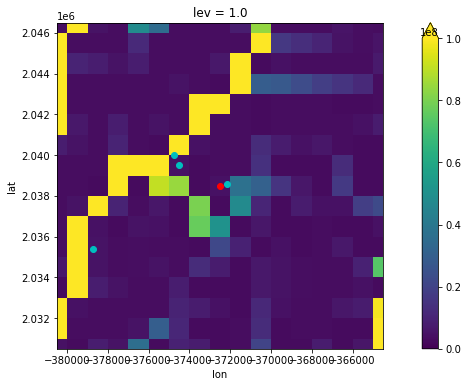

In [58]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e8,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-8000,dftest.y.values[0]+8000])
plt.xlim([dftest.x.values[0]-8000,dftest.x.values[0]+8000])

In [59]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  678
xidx =  372


(-381500.0, -365500.0)

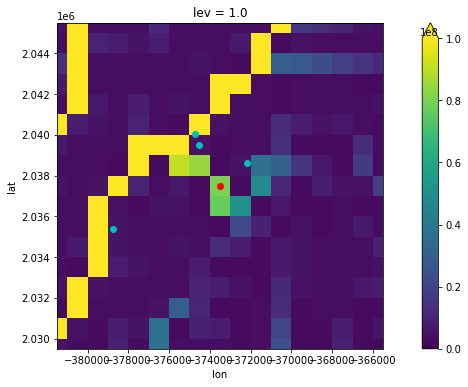

In [60]:
yidx = int(np.where(q.lat == slow.lat)[0]-1)
xidx = int(np.where(q.lon == slow.lon)[0]-1)
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e8,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-8000,dftest.y.values[0]+8000])
plt.xlim([dftest.x.values[0]-8000,dftest.x.values[0]+8000])

In [61]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

yidx fixed =  677
xidx fixed =  371


In [62]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [44]:
#indicies to save out
xidx7 = np.nan
yidx7 = np.nan

# 15980000

In [111]:
i=7
stnproj.site_no[i]

'15980000'

<AxesSubplot:title={'center':'lev = 1.0'}, xlabel='lon', ylabel='lat'>

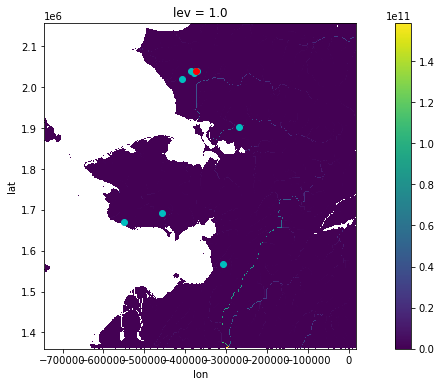

In [65]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15746990


(-377500.0, -371500.0)

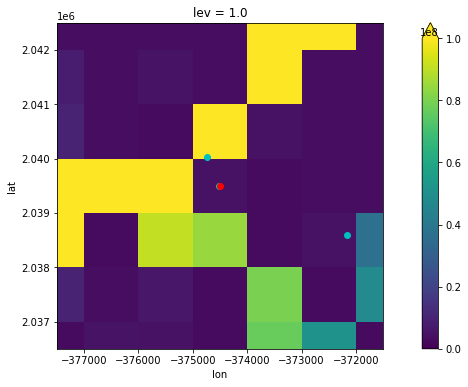

In [66]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e8,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-3000,dftest.y.values[0]+3000])
plt.xlim([dftest.x.values[0]-3000,dftest.x.values[0]+3000])

In [67]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  679
xidx =  370


Note: need to move the lat down by one pixel to reside in the modeled channel 

(-382500.0, -366500.0)

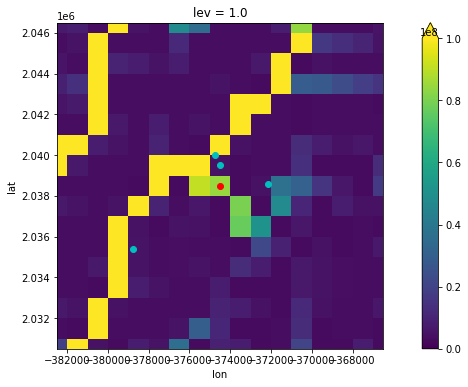

In [68]:
yidx = int(np.where(q.lat == slow.lat)[0]-1)
xidx = int(np.where(q.lon == slow.lon)[0])
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e8,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-8000,dftest.y.values[0]+8000])
plt.xlim([dftest.x.values[0]-8000,dftest.x.values[0]+8000])

In [69]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

yidx fixed =  678
xidx fixed =  370


In [70]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [63]:
#indicies to save out
xidx8 = np.nan
yidx8 = np.nan

# 15304000

In [45]:
i=8
stnproj.site_no[i]

'15304000'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

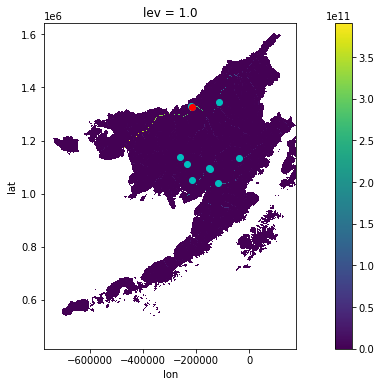

In [46]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15304000


(-223500.0, -207500.0)

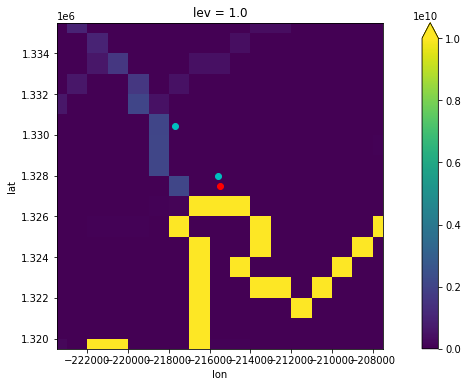

In [55]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e10,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-8000,dftest.y.values[0]+8000])
plt.xlim([dftest.x.values[0]-8000,dftest.x.values[0]+8000])

In [56]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  911
xidx =  556


(-223500.0, -207500.0)

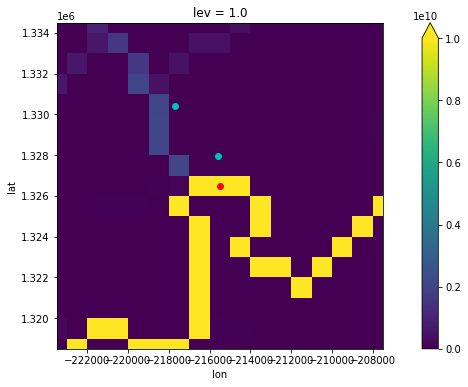

In [57]:
yidx = int(np.where(q.lat == slow.lat)[0]-1)
xidx = int(np.where(q.lon == slow.lon)[0])
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e10,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-8000,dftest.y.values[0]+8000])
plt.xlim([dftest.x.values[0]-8000,dftest.x.values[0]+8000])

In [58]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

yidx fixed =  910
xidx fixed =  556


In [51]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [59]:
#indicies to save out
xidx9 = int(xidx)
yidx9 = int(yidx)

# 15304010

In [60]:
i=9
stnproj.site_no[i]

'15304010'

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

In [ ]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e8,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-3000,dftest.y.values[0]+3000])
plt.xlim([dftest.x.values[0]-3000,dftest.x.values[0]+3000])

In [ ]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

In [ ]:
yidx = int(np.where(q.lat == slow.lat)[0]-1)
xidx = int(np.where(q.lon == slow.lon)[0])
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e8,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-8000,dftest.y.values[0]+8000])
plt.xlim([dftest.x.values[0]-8000,dftest.x.values[0]+8000])

In [ ]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

In [ ]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [61]:
#indicies to save out
xidx10 = np.nan
yidx10 = np.nan

## save data

In [64]:
# from anaylsis above
xidx = [xidx1,xidx2,xidx3,xidx4,xidx5,xidx6,xidx7,xidx8,xidx9,xidx10]
yidx = [yidx1,yidx2,yidx3,yidx4,yidx5,yidx6,yidx7,yidx8,yidx9,yidx10]

In [65]:
# add x and y idx to metadata
stnproj['xidx'] = xidx
stnproj['yidx'] = yidx
path=flowstnprojcal
stnproj.to_file(path, driver='GeoJSON') 

/nfs/attic/dfh/miniconda/envs/nprb/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
